# Вступление

Заказчик, в лице фермера-владельца молочного хозяйства "вольный луг" собирается расширить поголовье стада коров. Для этого он заключил контракт с ассоциацией пастбищ "ЭкоФерма".

Задача проекта.
Разработать модель МО для помощи в управлении рисками при отборе и покупке коров в его поголовье.
Для этого необходимо создать две прогнозные модели:

     - Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
     - Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак "Вкус молока").
Таким образом, с помощью моделей нужно отобрать коров по двум критериям:

     - средний удой за год — не менее 6000 килограммов;
     - молоко должно быть вкусным (соответствовать признаку "Вкус молока")
     
В комплекте с задачей идут три таблицы данные в которых предстоить изучить:

    - ferma_main.csv 
    - ferma_dad.csv 
    - cow_buy.csv 

# План работы

- Загрузить и первично осмотреть данные;
- Провести предобработку данных: пропуски, выбросы, дубликаты (явные/неявные), проверить содержимое и тип данных;
- провести исследовательский анализ дынных (посмотреть как в целом распределены все признаки данных);
- провести корреляционный анализ (выявить взаимосвязи входных и ключевых признаков, вычислить коэффициенты корреляции)
- построить модель линейной регрессии для прогнозирования удоя молока (разбивка на выборки, подготовка данных, обучение, оценка точности) и проведения прогноза;
- построить модель логистической регрессии для прогнозирования вкуса молока (разбивка на выборки, подготовка данных, обучение, оценка точности) и проведения прогноза;
- Добавление прогнозных данных к прогнозируемому стаду и написание вывода по всему исследованию.

Предисловие

Данный проект показался мне достаточно сложным. Выполнение его у меня заняло несколько дней. Я понимаю, что скорее всего в нем есть достаточное количество ошибок, поэтому прошу все недочеты по возможности максимально разъяснить. Коммуникация с преподаватель несколько затруднена, поэтому приходилось местами "упираться" в гугл. Заранее благодарю!

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import math
warnings.filterwarnings("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)


## Загрузка данных и первичный осмотр

### Загрузка и осмотр ferma_main.csv

In [2]:
fer_main_df = pd.read_csv('/datasets/ferma_main.csv', sep=';') # загружаем
display(fer_main_df.head(7))
print(fer_main_df.info())
display(fer_main_df.describe())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
5,6,5254,"12,7",1806,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,13","3,078",вкусно,менее_2_лет
6,7,5910,"13,2",1792,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,48","3,077",вкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

,id,"Удой, кг","Сырой протеин, г"
count,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,1922.682965
std,183.096982,1638.401021,182.392548
min,1.000000,5204.000000,1660.000000
25%,159.250000,5751.750000,1772.250000
50%,317.500000,6130.500000,1880.500000
75%,475.750000,6501.000000,2058.750000
max,629.000000,45616.000000,2349.000000


In [3]:
fer_dad_df = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
display(fer_dad_df.head(7))
print(fer_dad_df.info())
display(fer_dad_df.describe())

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


In [4]:
cow_buy_df = pd.read_csv('/datasets/cow_buy.csv', sep=";")
display(cow_buy_df.head(7))
print(cow_buy_df.info())
display(cow_buy_df.describe())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB
None


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
count,20,20,20,20,20,20,20
unique,2,2,2,4,12,12,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,"3,4","3,074",более_2_лет
freq,11,11,12,8,3,5,15


При загрузке данных, пришлось добавить разделитель ";" для того чтобы корректно записать их в датафреймы. В остальном на первый взгляд данные выглядят неплохо. Судя по всему пропуски в данных отсутствуют. На этапе предобработки желательно переименовать столбцы для соответствия змеиному_регистру и посмотреть на наличие дубликатов. Также следует проверить корректность типа данных во всех столбцах, а также значения в них, т.к. уже при первичном осмотре видно, что некоторые столбцы могли бы принадлежать типу данных float, а не object (к примеру, процент жирности или белка

 - Проверить странные значения в столбцах
 - Проверить дубликаты
 - Переименовать столбцы
 - Привести тип данных в соответствие содержимому
 

##  Предобработка данных

### Переименование столбцов

#### Переименование столбцов fer_main_df

Для начала, для удобства дальнейшей обработки данных столбцы во всех дф необходимо привести к snake_case. Сделаем это:

In [5]:
fer_main_df.columns = ['id', 'yield_kg', 'efu', 'crude_prot_gr', 'sugar_prot_ratio', 'breed', 'pasture_type', 'dad_breed', 'fat_%', 'prot_%', 'tasty', 'age']
print(fer_main_df.columns)
print(fer_main_df.head(5))

Index(['id', 'yield_kg', 'efu', 'crude_prot_gr', 'sugar_prot_ratio', 'breed',
       'pasture_type', 'dad_breed', 'fat_%', 'prot_%', 'tasty', 'age'],
      dtype='object')
   id  yield_kg   efu  crude_prot_gr sugar_prot_ratio            breed  \
0   1      5863  14,2           1743             0,89   Вис Бик Айдиал   
1   2      5529  12,8           2138             0,89   Вис Бик Айдиал   
2   3      5810    14           1854            0,885  РефлешнСоверинг   
3   4      5895  12,4           2012            0,885  РефлешнСоверинг   
4   5      5302  12,8           1675            0,885   Вис Бик Айдиал   

  pasture_type dad_breed fat_% prot_%      tasty          age  
0    Равнинное    Айдиал  3,58  3,076     вкусно  более_2_лет  
1    Равнинные   Соверин  3,54  3,079     вкусно  менее_2_лет  
2    Холмистое   Соверин  3,59  3,074  не вкусно  более_2_лет  
3    Холмистое    Айдиал   3,4  3,075  не вкусно  более_2_лет  
4    Равнинные   Соверин  3,73  3,073     вкусно  менее_2_лет  

#### Переименование столбцов fer_dad_df

In [6]:
fer_dad_df.columns = ['id', 'dad_name']
print(fer_dad_df.columns)
print(fer_dad_df.head())

Index(['id', 'dad_name'], dtype='object')
   id  dad_name
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин


#### Переименование столбцов в cow_buy_df

In [7]:
cow_buy_df.columns = ['breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_current_%', 'prot_current_%', 'age']
print(cow_buy_df.columns)
print(cow_buy_df.head())

Index(['breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_current_%',
       'prot_current_%', 'age'],
      dtype='object')
             breed pasture_type dad_breed  dad_name fat_current_%  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес          3,58   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный          3,54   
2  РефлешнСоверинг    равнинное   Соверин     Барин          3,59   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный           3,4   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный          3,64   

  prot_current_%          age  
0          3,076  более_2_лет  
1          3,081  менее_2_лет  
2          3,074  более_2_лет  
3          3,061  более_2_лет  
4          3,074  более_2_лет  


### Проверка на пропуски и странные значения в столбцах

В предыдущей главе с помощью метода info() мы увидели, что явных пропусков типа NaN в датафреймах нет, тем не менее прошлый проект (посвященный видеоиграм) показал, что пропуски бывают неявными (речь идет о значении "tbd" - в значениях рейтинга в прошлом проекте). С помощью вывода уникальных значений мы сможем во-первых посмотреть нет ли странных значений в столбцах и заодно убедится, нет ли неявных пропусков в столбцах. Займемся этим.

#### Уникальные значения в fer_main_df

In [8]:
for col in fer_main_df.columns:
    print('Уникальные значения столбца', col)
    print(fer_main_df[col].unique())
    print()


Уникальные значения столбца id
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239

Анализ уникальных значений (а также метод describe() выявил следующие недостатки заполнения датафрейма:
    
    - в столбце "yield_kg" есть выброс - значение 45616 при среднем 6187 и медианном 6130; скорее всего это опечатка, данную строку заполним медианной, она всего одна;
    - в столбце "pasture_type" есть неявный дубликат - значения "Равнинное" и "Равнинные" одинаковы в данном случае по смыслу, заменим "Равнинные" на "Равнинное";
    - в столбце "dad_breed" также неявный дубликат - "Айдиал" и "Айдиалл" - одинковые значения, заменим всё на "Айдиал", гугл выдал такое значение как правильное;
    - у некоторых колонок неверно определен тип данных;
    - строк у датафрейма 634, а уникальные значения в id заканчиваются на 629...а мы пока ничего не удаляли. Дубликаты?

In [9]:
fer_main_df.loc[fer_main_df['yield_kg'] == 45616, 'yield_kg'] = fer_main_df['yield_kg'].median().round(0) #меняем на медиану
print(fer_main_df.describe()) # проверяем, нет ли больше выбросов
print()
print(fer_main_df.iloc[16]) #Проверяем строку, где меняли значение
print()
print('Тип данных столбца yield_kg после замены значения выброса на медиану:', fer_main_df['yield_kg'].dtypes) # тип данных после замены на медиану поменялся на float
print()
fer_main_df['yield_kg'] = fer_main_df['yield_kg'].astype(int) #все значения были целыми, вернем тип данных на int
print('Тип данных столбца yield_kg (исправленный):', fer_main_df['yield_kg'].dtypes) #проверяем

               id     yield_kg  crude_prot_gr
count  634.000000   634.000000     634.000000
mean   317.460568  6124.744479    1922.682965
std    183.096982   473.797699     182.392548
min      1.000000  5204.000000    1660.000000
25%    159.250000  5751.750000    1772.250000
50%    317.500000  6130.000000    1880.500000
75%    475.750000  6500.250000    2058.750000
max    629.000000  7222.000000    2349.000000

id                              17
yield_kg                    6130.0
efu                           11,5
crude_prot_gr                 1675
sugar_prot_ratio              0,93
breed               Вис Бик Айдиал
pasture_type             Холмистое
dad_breed                  Айдиалл
fat_%                         3,22
prot_%                       3,076
tasty                       вкусно
age                    более_2_лет
Name: 16, dtype: object

Тип данных столбца yield_kg после замены значения выброса на медиану: float64

Тип данных столбца yield_kg (исправленный): int64


In [10]:
fer_main_df['pasture_type'] = fer_main_df['pasture_type'].replace('Равнинные', 'Равнинное') #Заменим "Равнинные" на "Равнинное"
fer_main_df['pasture_type'].unique() #Проверим

array(['Равнинное', 'Холмистое'], dtype=object)

In [11]:
fer_main_df['dad_breed'] = fer_main_df['dad_breed'].replace('Айдиалл', 'Айдиал') #Заменим "Айдиалл" на "Айдиал"
fer_main_df['dad_breed'].unique() #Проверим

array(['Айдиал', 'Соверин'], dtype=object)

In [12]:
print(fer_main_df.info()) #еще раз посмотри на тип данных в столбцах и проведем необходимые замены:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                634 non-null    int64 
 1   yield_kg          634 non-null    int64 
 2   efu               634 non-null    object
 3   crude_prot_gr     634 non-null    int64 
 4   sugar_prot_ratio  634 non-null    object
 5   breed             634 non-null    object
 6   pasture_type      634 non-null    object
 7   dad_breed         634 non-null    object
 8   fat_%             634 non-null    object
 9   prot_%            634 non-null    object
 10  tasty             634 non-null    object
 11  age               634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB
None


In [13]:
fer_main_df['efu'] = fer_main_df['efu'].replace(',', '.', regex=True).astype(float)
fer_main_df['sugar_prot_ratio'] = fer_main_df['sugar_prot_ratio'].replace(',', '.', regex=True).astype(float)
fer_main_df['fat_%'] = fer_main_df['fat_%'].replace(',', '.', regex=True).astype(float)
fer_main_df['prot_%'] = fer_main_df['prot_%'].replace(',', '.', regex=True).astype(float)
print(fer_main_df.info())
display(fer_main_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   yield_kg          634 non-null    int64  
 2   efu               634 non-null    float64
 3   crude_prot_gr     634 non-null    int64  
 4   sugar_prot_ratio  634 non-null    float64
 5   breed             634 non-null    object 
 6   pasture_type      634 non-null    object 
 7   dad_breed         634 non-null    object 
 8   fat_%             634 non-null    float64
 9   prot_%            634 non-null    float64
 10  tasty             634 non-null    object 
 11  age               634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB
None


,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


#### Уникальные значения в fer_dad_df

In [14]:
print('Размер датафрейма', fer_dad_df.shape)
print('Уникальные значения', fer_dad_df.iloc[:, 1].unique())
display(fer_dad_df.head())

Размер датафрейма (629, 2)
Уникальные значения ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


Тут вроде бы все нормально. Похоже, что даже дубликатов нет.

#### Уникальные значения в cow_buy_df

In [15]:
for col in cow_buy_df.columns:
    print('Уникальные значения столбца', col)
    print(cow_buy_df[col].unique())
print('Размер датафрейма',cow_buy_df.shape)
print(cow_buy_df.info())

Уникальные значения столбца breed
['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения столбца pasture_type
['холмистое' 'равнинное']
Уникальные значения столбца dad_breed
['Айдиал' 'Соверин']
Уникальные значения столбца dad_name
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Уникальные значения столбца fat_current_%
['3,58' '3,54' '3,59' '3,4' '3,64' '3,63' '3,57' '3,73' '3,68' '3,42'
 '3,77' '3,34']
Уникальные значения столбца prot_current_%
['3,076' '3,081' '3,074' '3,061' '3,053' '3,079' '3,055' '3,073' '3,046'
 '3,075' '3,065' '3,069']
Уникальные значения столбца age
['более_2_лет' 'менее_2_лет']
Размер датафрейма (20, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   breed           20 non-null     object
 1   pasture_type    20 non-null     object
 2   dad_breed       20 non-null     object
 3   dad_name        20 non-null     object
 

Аналогичная fer_main_df ситуация с определением данных в столбцах fat_current_% и prot_current_%. Исправим:

In [16]:
cow_buy_df['fat_current_%'] = cow_buy_df['fat_current_%'].replace(',', '.', regex=True).astype(float)
cow_buy_df['prot_current_%'] = cow_buy_df['prot_current_%'].replace(',', '.', regex=True).astype(float)
print(cow_buy_df.info())
display(cow_buy_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   breed           20 non-null     object 
 1   pasture_type    20 non-null     object 
 2   dad_breed       20 non-null     object 
 3   dad_name        20 non-null     object 
 4   fat_current_%   20 non-null     float64
 5   prot_current_%  20 non-null     float64
 6   age             20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None


,breed,pasture_type,dad_breed,dad_name,fat_current_%,prot_current_%,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Ну вроде бы всё поправили. Осталось проверить все дф на наличие явных дубликатов.

### Проверка на наличие явных дубликатов (все 3  датафрейма)

In [17]:
print("Найденные дубликаты:", fer_main_df.duplicated().sum()) # Выводим информацию о дубликатах в fer_main_df

fer_main_df = fer_main_df.drop_duplicates() # Удаляем явные дубликаты

print("дубликатов после удаления:") # Проверяем
print(fer_main_df.duplicated().sum())
print('Размер ДФ после удаления дубликатов:', fer_main_df.shape)

Найденные дубликаты: 5
дубликатов после удаления:
0
Размер ДФ после удаления дубликатов: (629, 12)


Вот и выровнялось количество строк и количество id коров в данном ДФ. Идем дальше:

In [18]:
print("Найденные дубликаты:", fer_dad_df.duplicated().sum()) # Выводим информацию о дубликатах в fer_dad_df

Найденные дубликаты: 0


In [19]:
#print('Дубликатов найдено', cow_buy_df.duplicated().sum()) # Выводим информацию о дубликатах в cow_buy_df
#cow_buy_df = cow_buy_df.drop_duplicates() # Удаляем явные дубликаты
#print("дубликатов после удаления:", cow_buy_df.duplicated().sum())

Похоже для покупки отобрали целых 4 дублирующих коровы. Или это не дубликаты? Без id сложно будет понять. Попробуем проверить, есть ли в fer_main_df полностью совпадающие по признакам коровы (т.е. у них должно совпадать всё кроме "id").
P.S. не уверен за код ниже из-за метода "difference" - не использовал его ранее.

In [20]:
column_to_ignore = 'id' # Столбец, который нужно игнорировать при поиске дубликатов

# Поиск явных дубликатов, игнорируя столбец column_to_ignore
duplicates = fer_main_df.duplicated(subset=fer_main_df.columns.difference([column_to_ignore])).sum()

# Вывод информации о найденных дубликатах
print("Найденные дубликаты, игнорируя столбец", column_to_ignore, ':', duplicates)

Найденные дубликаты, игнорируя столбец id : 0


In [21]:
cow_buy_df.shape

(20, 7)

Если здесь всё верно, то удаление дубликтов в дф cow_buy_df - верное решение.

### Объединение fer_main_df и fer_dad_df

Не вижу смысла в существовании отдельного дф с именами отцов-быков, приклеим эту информацию к основному дф.

In [22]:
df= pd.merge(fer_main_df, fer_dad_df, on='id') # склеиваем
display(df.head(5)) # проверяем
display(df.tail(5)) 

,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name
624,625,6812,15.4,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
625,626,5513,12.9,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Барин
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Барин
627,628,5746,13.8,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,Барин
628,629,6503,16.2,2283,0.94,Вис Бик Айдиал,Холмистое,Соверин,3.71,3.076,вкусно,более_2_лет,Соловчик


Вроде бы всё неплохо склеилось. Сделаем выводы по предобработке.

### Выводы по предобработке

В результате проведенной предобработки данных были произведены следующие операции над датафреймами:
    
    - Переименованы столбцы во всех дф по правилам snake_case;
    - Был обработан один выброс (скорее всего опечатка), путём замены его на медианное значение в столбце yield_kg(удой);
    - Были обработаны неявные дубликаты в столбцах dad_breed и pasture_type;
    - Были удалены явные дубликаты из fer_main_df и cow_buy_df;
    - Тип данных был изменен на более подходящий в случаях когда он был ошибочно определен;
    - объединены дф fer_main_df и fer_dad_df в один.
Данные готовы к исследовательскому анализу.

## Исследовательский анализ данных

In [23]:
display(df.head())

,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


Для описания типа распределения возьмем шпаргалку из интернета

In [24]:
from IPython.display import Image
Image(url='https://blog.kinetica.su/uploads/widget/image/faedab80554a84482b4a8b331054f9ba65b244d3.png')

### yield_kg

In [25]:
df['yield_kg'].describe()

count     629.000000
mean     6125.974563
std       475.478062
min      5204.000000
25%      5751.000000
50%      6132.000000
75%      6501.000000
max      7222.000000
Name: yield_kg, dtype: float64

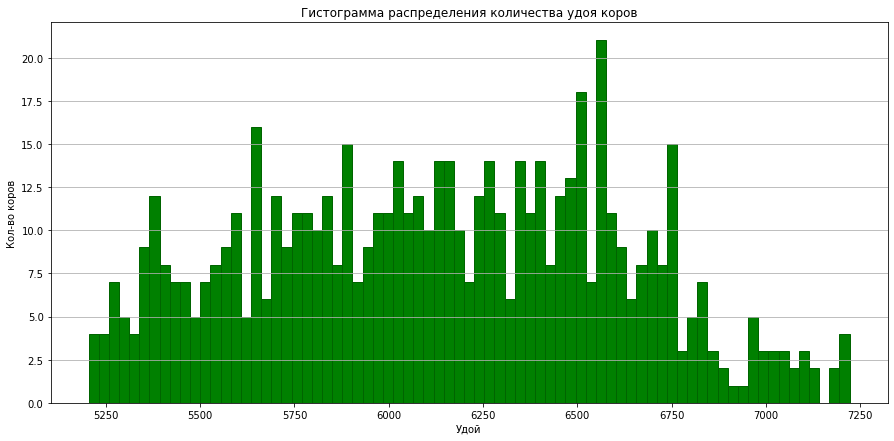

In [26]:
df['yield_kg'].plot(kind='hist', grid=True, figsize = (15,7), bins=75, color='green', edgecolor='darkgreen')
plt.title('Гистограмма распределения количества удоя коров')
plt.grid (axis='x')
plt.xlabel('Удой')
plt.ylabel('Кол-во коров')
plt.show()

Поставим поменьше корзин.

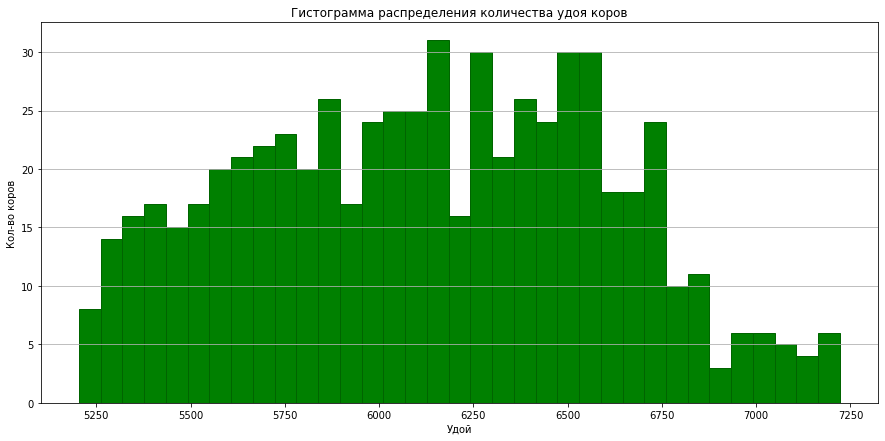

In [27]:
df['yield_kg'].plot(kind='hist', grid=True, figsize = (15,7), bins=35, color='green', edgecolor='darkgreen')
plt.title('Гистограмма распределения количества удоя коров')
plt.grid (axis='x')
plt.xlabel('Удой')
plt.ylabel('Кол-во коров')
plt.show()

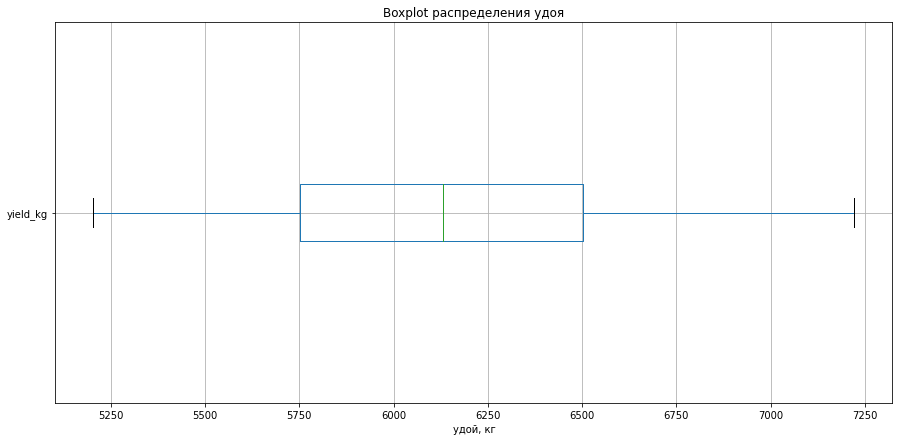

In [28]:
df['yield_kg'].plot(kind='box', grid=True, vert=False, figsize = (15,7))
plt.title('Boxplot распределения удоя')
plt.xlabel('удой, кг')
plt.show()

Осмотрев данные по удою, можно сказать, что характер их распределения больше всего похож на гамма-распределение. Есть на разных значениях "взлеты и падения" но, при выборе меньшего количества корзин при построении гистограммы эта ситуация сгладилась. На более детальной гистограмме есть несколько скачков частоты на 6500-6600 кг в год, но пока трудно сказать почему оно так. Минимум удоя - 5204, максимум - 7222, среднее и медиана практически одинаковы: 6125 и 6130 кг соответственно. Выбросов нет.

### efu

In [29]:
df['efu'].describe()

count    629.000000
mean      14.543879
std        1.306408
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efu, dtype: float64

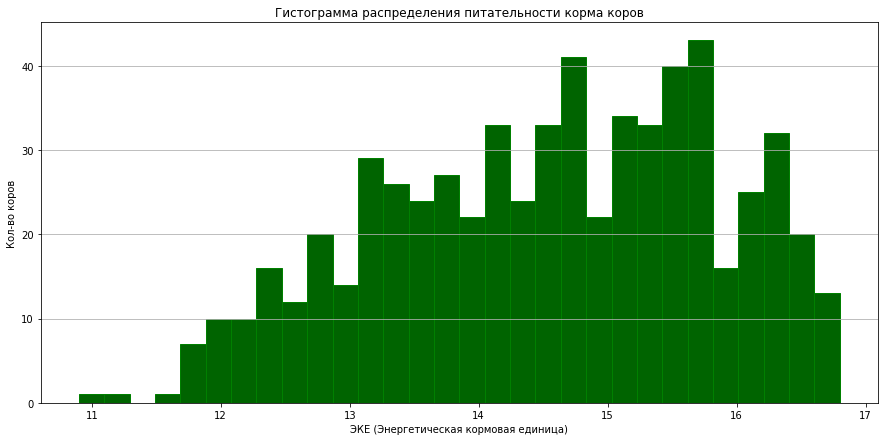

In [30]:
df['efu'].plot(kind='hist', grid=True, figsize = (15,7), bins=30, color='darkgreen', edgecolor='green')
plt.title('Гистограмма распределения питательности корма коров')
plt.grid (axis='x')
plt.xlabel('ЭКЕ (Энергетическая кормовая единица)')
plt.ylabel('Кол-во коров')
plt.show()

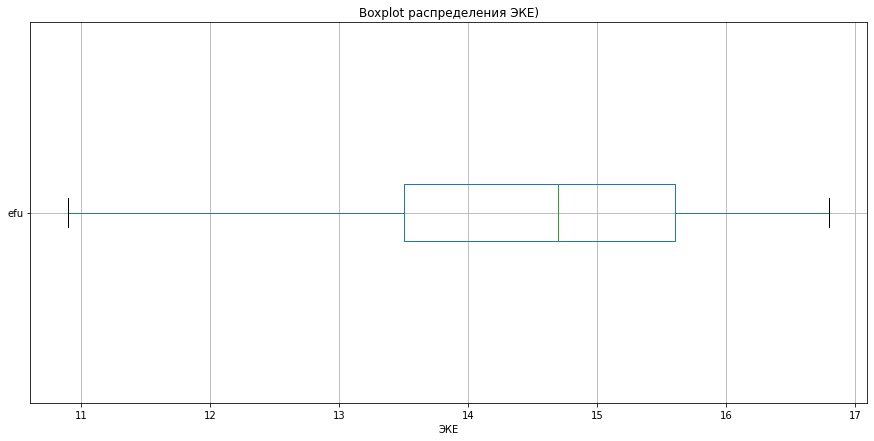

In [31]:
df['efu'].plot(kind='box', grid=True, vert=False, figsize = (15,7))
plt.title('Boxplot распределения ЭКЕ)')
plt.xlabel('ЭКЕ')
plt.show()

Данные отдаленно напоминают бета-распределение, чаще всего коровы получают 13-15 ЭКЕ, реже всего чуть меньше 11 , при этом максимальное значение зафиксировано на 16,8 ЭКЕ. Среднее и медиана также очень близки 14,54 и 14,7 соответственно. Выбросов нет.

### crude_prot_gr

In [32]:
df['crude_prot_gr'].describe()

count     629.000000
mean     1923.364070
std       182.956251
min      1660.000000
25%      1771.000000
50%      1888.000000
75%      2062.000000
max      2349.000000
Name: crude_prot_gr, dtype: float64

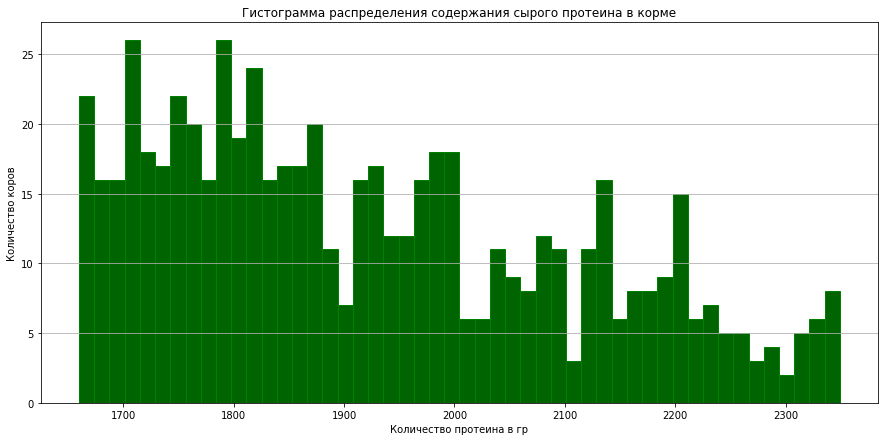

In [33]:
df['crude_prot_gr'].plot(kind='hist', grid=True, figsize = (15,7), bins=50, color='darkgreen', edgecolor='green')
plt.title('Гистограмма распределения содержания сырого протеина в корме')
plt.grid (axis='x')
plt.xlabel('Количество протеина в гр')
plt.ylabel('Количество коров')
plt.show()

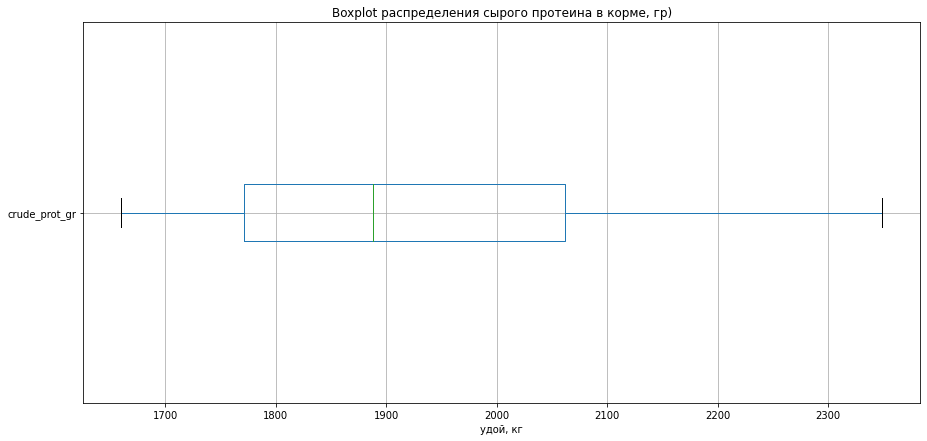

In [34]:
df['crude_prot_gr'].plot(kind='box', grid=True, vert=False, figsize = (15,7))
plt.title('Boxplot раcпределения сырого протеина в корме, гр)')
plt.xlabel('удой, кг')
plt.show()

Распределение больше всего не похоже на нормальное. В среднем сырого протеина в корме коров порядка 1500-2000 гр. Есть небольшая просадка около 1870-1930 гр. При этом в данных есть выбросы которые показывают, что около 10 коров получают ~2130 и ~2210 гр протеина с кормом. Минимальное содержание протеина в корме 1660, максимальное 2350. Среднее и медиана также достаточно близки 1923 и 1888 гр соответственно. Выбросов нет.

### sugar_prot_ratio

In [35]:
df['sugar_prot_ratio'].describe()

count    629.000000
mean       0.913116
std        0.032203
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: sugar_prot_ratio, dtype: float64

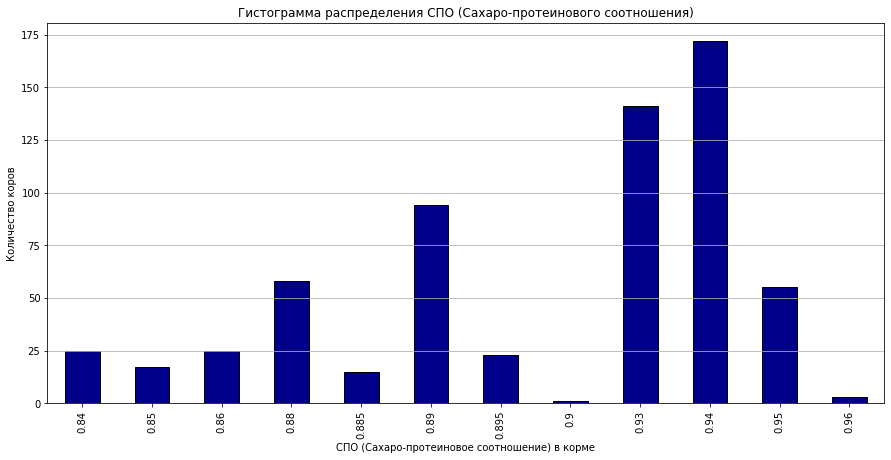

In [36]:
df.groupby('sugar_prot_ratio')['id'].count().plot(kind='bar', grid=True, figsize = (15,7), color='darkblue', edgecolor='black')
plt.title('Гистограмма распределения СПО (Сахаро-протеинового соотношения)')
plt.grid (axis='x')
plt.xlabel('СПО (Сахаро-протеиновое соотношение) в корме')
plt.ylabel('Количество коров')
plt.show()

Распределение не нормальное. Они показывают, что в среднем корм коров имеет СПО в районе 0,93-0,94. При этом также достаточное количество коров получает корм с СПО около 0,88-0,89. Минимальное значение СПО - 0,84 - при этом такой корм получает также некоторое количество коров. Корм с максимальным СПО получает очень мало коров, но меньше всего коровы едят корм с СПО равным 0,9.

### breed

Некоторые параметры похожи по распределению, создадим для таковых функцию:

In [37]:
def analyze_column(df, column_name):
    # Вывод количества значений по группам
    print(df.groupby(column_name)['id'].count())
    
    # Построение круговой диаграммы
    df.groupby(column_name)['id'].count().plot(kind='pie', autopct='%1.1f%%')
    plt.show()

breed
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: id, dtype: int64


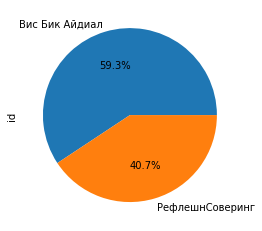

In [38]:
analyze_column(df, 'breed') #Применим функцию

В генеральной совокупности представлено всего 2 породы коров - Вис бик Айдиал (59%) и РефлешнСоверинг (41%). Больше особо комментировать здесь нечего.

### pasture_type

pasture_type
Равнинное    278
Холмистое    351
Name: id, dtype: int64


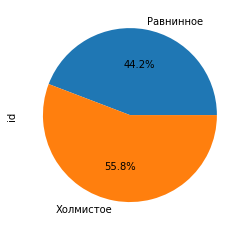

In [39]:
analyze_column(df, 'pasture_type') #Применим функцию

В генеральной совокупности представлено всего 2 типа пастбища - холмистое (56%) и Равнинное (44%). Больше особо комментировать здесь также нечего.

### dad_breed	

dad_breed
Айдиал     318
Соверин    311
Name: id, dtype: int64


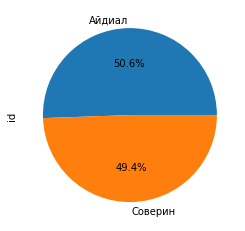

In [40]:
analyze_column(df, 'dad_breed') #Применим функцию

В генеральной совокупности представлено всего 2 породы отца - Айдиал (50,6%) и Соверин (49,4%). Больше особо комментировать здесь также нечего.

### fat_%

In [41]:
df['fat_%'].describe()

count    629.000000
mean       3.603657
std        0.168656
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_%, dtype: float64

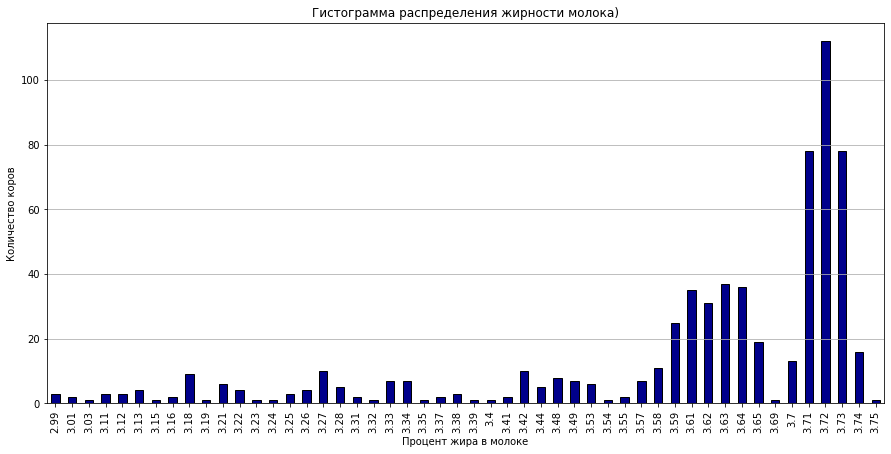

In [42]:
df.groupby('fat_%')['id'].count().plot(kind='bar', grid=True, figsize = (15,7), color='darkblue', edgecolor='black')
plt.title('Гистограмма распределения жирности молока)')
plt.grid (axis='x')
plt.xlabel('Процент жира в молоке')
plt.ylabel('Количество коров')
plt.show()

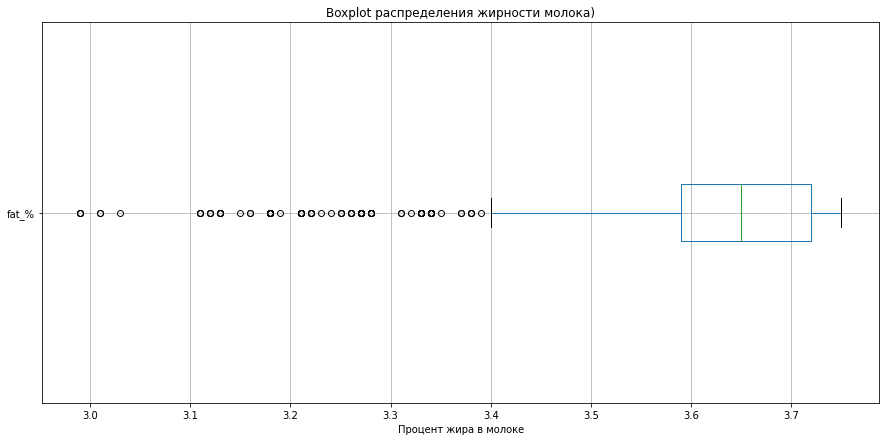

In [43]:
df['fat_%'].plot(kind='box', grid=True, vert=False, figsize = (15,7))
plt.title('Boxplot распределения жирности молока)')
plt.xlabel('Процент жира в молоке')
plt.show()

Распределение больше всего похоже на бимодальное с большим количеством выбросов. По данным видно, что нормальные значения жирности молока находятся в пределах 3,4 - 3,75% (среднее 3,6%, медиана 3,65%). Большинство коров имеют показатель жирности молока в диапазоне 3,58-3,74%. При этом исходя из boxplot видно, что данные имеют большое количество выбросов - значений жирности ниже 3,4%. С чем связано и с чем коррелирует этот показатель предстоит узнать далее в исследовании.

### prot_%¶

In [44]:
df['prot_%'].describe()

count    629.000000
mean       3.075671
std        0.002549
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: prot_%, dtype: float64

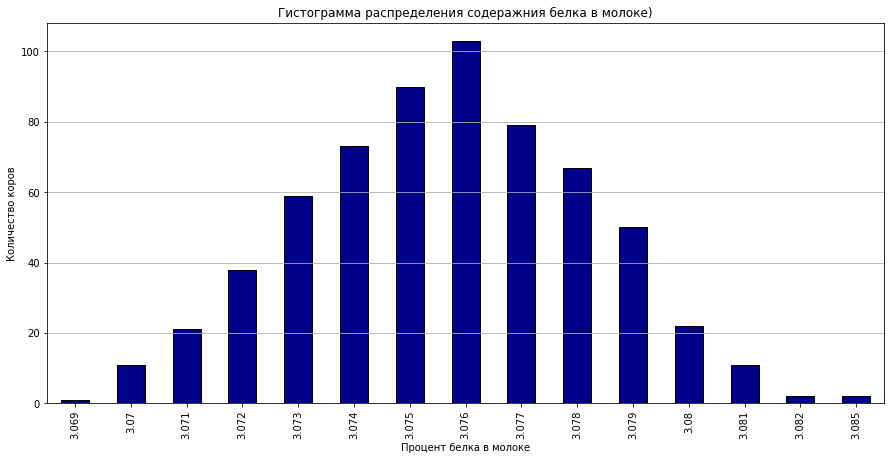

In [45]:
df.groupby('prot_%')['id'].count().plot(kind='bar', grid=True, figsize = (15,7), color='darkblue', edgecolor='black')
plt.title('Гистограмма распределения содеражния белка в молоке)')
plt.grid (axis='x')
plt.xlabel('Процент белка в молоке')
plt.ylabel('Количество коров')
plt.show()

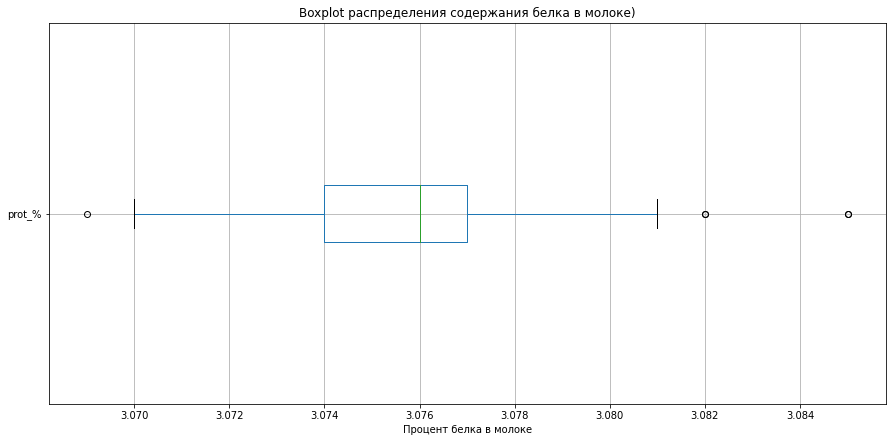

In [46]:
df['prot_%'].plot(kind='box', grid=True, vert=False, figsize = (15,7))
plt.title('Boxplot распределения содержания белка в молоке)')
plt.xlabel('Процент белка в молоке')
plt.show()

Распределение похоже на нормальное. Средняя и медина практически совпадают - 3,076%. Минимальное значение содержания белка - 3,069, максимальное - 3,085%. Выбросов совсем немного исходя из boxplot. Возможно они обусловлены какими-нибудь особенностями коров.

### tasty

tasty
вкусно       371
не вкусно    258
Name: id, dtype: int64


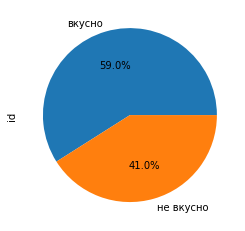

In [47]:
analyze_column(df, 'tasty') #Применим функцию

Хоть и отрыв небольшой, но исходя из графика видно, что фермер не предъявляет каких-то завышенных требованиям к вкусу молока и почти ~60% молока коров генеральной совокупности он считает вкусным.

### age

age
более_2_лет    519
менее_2_лет    110
Name: id, dtype: int64


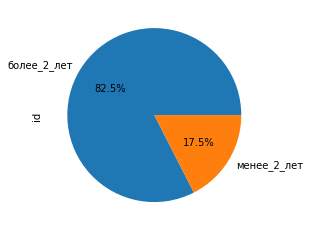

In [48]:
analyze_column(df, 'age') #Применим функцию

Как видно из графика, в генеральной совокупности преобладают коровы старше 2 лет (82,5%), остальная часть - это молодые коровы, моложе 2 лет.

### dad_name

dad_name
Барин       240
Буйный      215
Геркулес     64
Соловчик    110
Name: id, dtype: int64


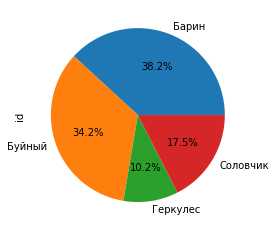

In [49]:
analyze_column(df, 'dad_name') #Применим функцию

Как видно из графика и данных самые плодовитые в ГС это Барин(~38%) и Буйный(~34%). Соловчик занимает почетное третье место с 17,5%, а замыкает рейтинг Геркулес с 10,2%.

### Вывод по ИАД

На этапе исследовательского анализа данных были проанализированы количественные и категориальные признаки корма и коров. Каждый признак имеет свое распределение. Некоторые похожи на нормальное (содержание протеина в молоке, энергитическая кормовая единица), другие больше похожи на бимодальное (жир в молоке) при этом имеют огромное количество выбросов. Некоторые признаки распределены достаточно равномерно, другие наоборот скачкообразно (к примеру, СПО). Категориальные признаки там где признака всего 2 распрделены практически поровну (40/60%), исключение - возраст коров. Признак распределения отца-быка имеет 4 варианта, он распредлен неравномерно.

Подводя итог по ИАД:

    Как правило, средняя корова из представленной ГС дает около 6130 кг молока в год, жирностью 3,4-3,75% и содержанием белка 3,07%, немного чаще фермер находит молоко вкусным, чем невкусным. Наиболее типичная корова из ГС будет старше 2 лет, породы Вис Бик Айдиал, отец которой либо Барин либо Буйный (Соверин или Айдиал - соответственно). Пасется такая корова, как правило, на холмистой местности, получает 13-15 ЭКЕ. Содержание сырого протеина в корме - около 1500-2000 гр, сахаро-протеиновое-соотношение 0,93-0,94%.
    
    Скорее всего, нужно будет поработать над данными, в которых имеется много выбросов - процента жира в молоке. Их будет необходимо улучшить. Некоторые улучшения мы уже провели - обработали дубликаты, убрали один выброс, склеили два датафрейма. Для построения модели данные для обучения в любом случае будут проходить подготовку.

## Корреляционный анализ

У нас есть данные которые распределены не нормально. Исходя из этого построим матрицу корреляций по критерию Спирмана, он более универсален в нашем случае:

In [50]:
df.corr(method='spearman')

,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,fat_%,prot_%
id,1.000000,-0.002997,-0.017754,-0.032749,-0.021522,0.042483,0.003334
yield_kg,-0.002997,1.000000,0.763408,0.436764,0.788205,0.687302,-0.005714
efu,-0.017754,0.763408,1.000000,0.387436,0.740029,0.688273,-0.013803
crude_prot_gr,-0.032749,0.436764,0.387436,1.000000,0.484731,0.395286,0.228104
sugar_prot_ratio,-0.021522,0.788205,0.740029,0.484731,1.000000,0.699606,0.109788
fat_%,0.042483,0.687302,0.688273,0.395286,0.699606,1.000000,0.042541
prot_%,0.003334,-0.005714,-0.013803,0.228104,0.109788,0.042541,1.000000


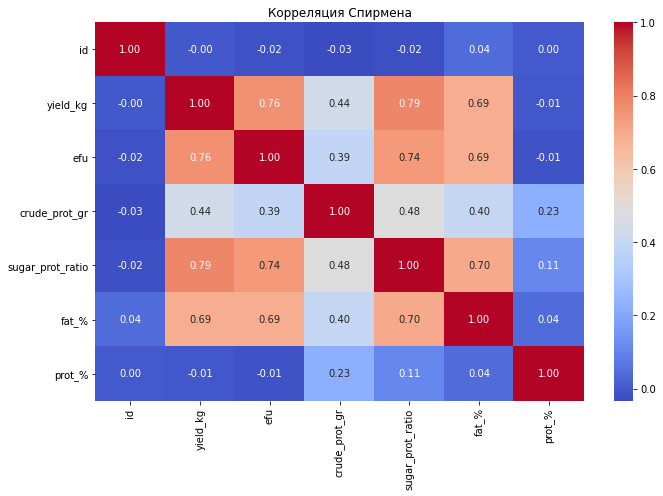

In [51]:
# Рассчет корреляции Спирмена
spearman_cor_mat = df.corr(method='spearman')

# Настройка размера фигуры и подграфиков
plt.figure(figsize=(10, 7))

# Вторая тепловая карта для корреляции Спирмена
plt.plot(1, 3, 2)
sns.heatmap(spearman_cor_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляция Спирмена")


plt.tight_layout()
plt.show()

На представленной матрице корреляция сильных зависимостей (>0,9) между признаками не выявлено, отсюда можно сделать вывод, что мультиколлинеарность в нашем случае отсутствует.

Итак, мы видим по крайней мере несколько достаточно сильных линейных зависимостей между признаками. В их числе:

    - На удой влияет количество ЭКЕ и СПО и немного количество сырого протеина в молоке;
    - На жирность молока также влияет ЭКЕ и СПО;
    - Странно, но соотношение сырого протеина почти не влияет на количество белка в молоке (остальные параметры вообще никак не влияют);
    - есть некоторая связь между удоем и жирностью молока, вряд ли эти два параметра связаны.

### Scatterplot'ы c учетом породы (breed)

Воспользуемся шпаргалкой

In [52]:
Image(url='https://static.tildacdn.com/tild3663-3866-4234-a534-313336643631/image.png')

Напишем функцию для постройки графиков:

In [53]:
def scatterplot_with_hue(df, hue):
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
    numerical_features = numerical_features.drop('yield_kg')

    num_plots = len(numerical_features)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4*num_rows))

    for i, feature in enumerate(numerical_features):
        row = i // num_cols
        col = i % num_cols

        sns.scatterplot(x='yield_kg', y=feature, hue=hue, data=df, ax=axes[row, col])
        axes[row, col].set_title(f"Диаграмма рассеяния для yield_kg и {feature}")
        axes[row, col].grid(True)


    plt.tight_layout()
    plt.show()


Построим scatterplot для категориального признака breed:

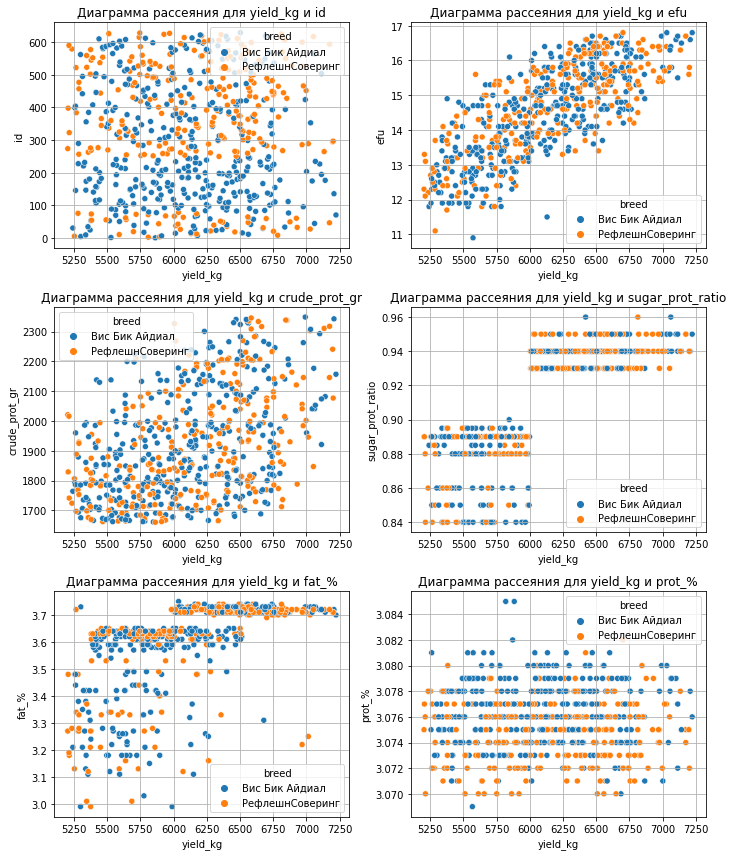

In [54]:
scatterplot_with_hue(df, 'breed')

Исходя из построенных графиков, можно сказать, что порода практически никак не влияет на распределение количественных величин.

    1) Породы распределены случайным образом, есть "линия" между 100-200 id - скорее всего это свидетельствует о покупке партии этой породы.
    2) График зависимости удоя от ЭКЕ подтверждает линейную зависимость, породы при этом никак не влияют на него.
    3) Подтверждается небольшая линейная зависимость между содержание сырого протеина в корме и количеством удоя, породы никак не влияют на это.
    4) Зависимость между удоем и СПО носит линейный характер, несмотря на то, что график несовсем хорошо её отражает из-за отстутвия данных по промежутку СПО в районе 0,93. Породы роли в данном случае не играют.
    5) Порода никак не влияет на жирность молока, при этой характер взаимосвязи между удоем и жирностью молока имеет среднюю линейную зависимость.
    6) График показывает, что коровы породы Вис Бик Айдиал, как правило,  дают молоко с несколько большим содержанием белка. При этом связи между содержанием бедка в молоке и количеством удоя нет.

### Scatterplot'ы c учетом типа пастбищ (pasture_type)

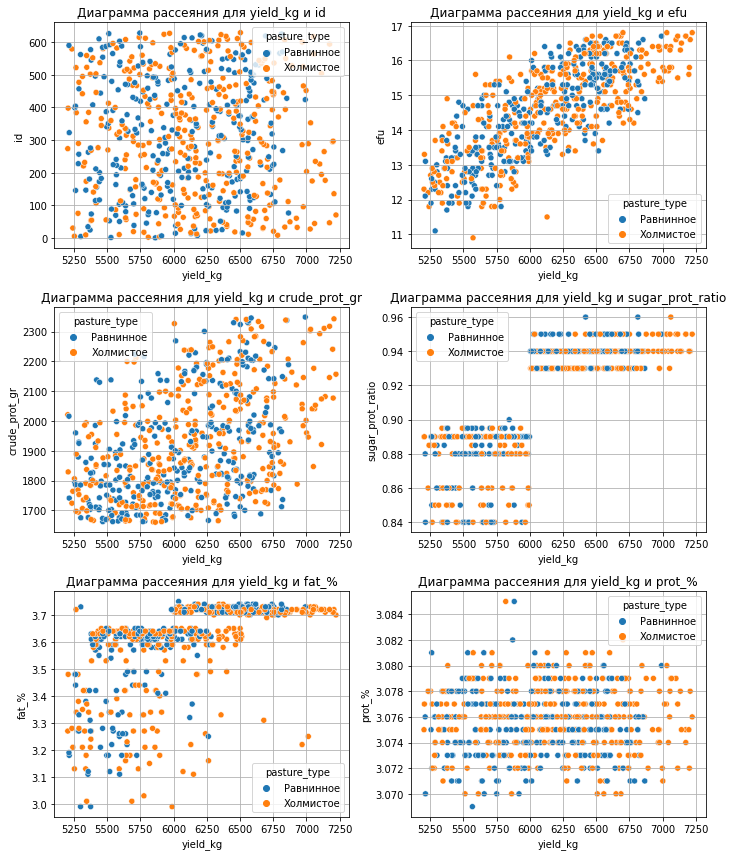

In [55]:
scatterplot_with_hue(df, 'pasture_type')

Исходя из построенных графиков, можно сказать, что тип пастбища практически никак не влияет на среднее распределение количественных величин удоя. Единственное, максимальные показатели по удою у коров пасущихся на холмистой местности. В остальном характер распределения остался тем же, что и по признаку порода.


### Scatterplot'ы c учетом породы отца (dad_breed)

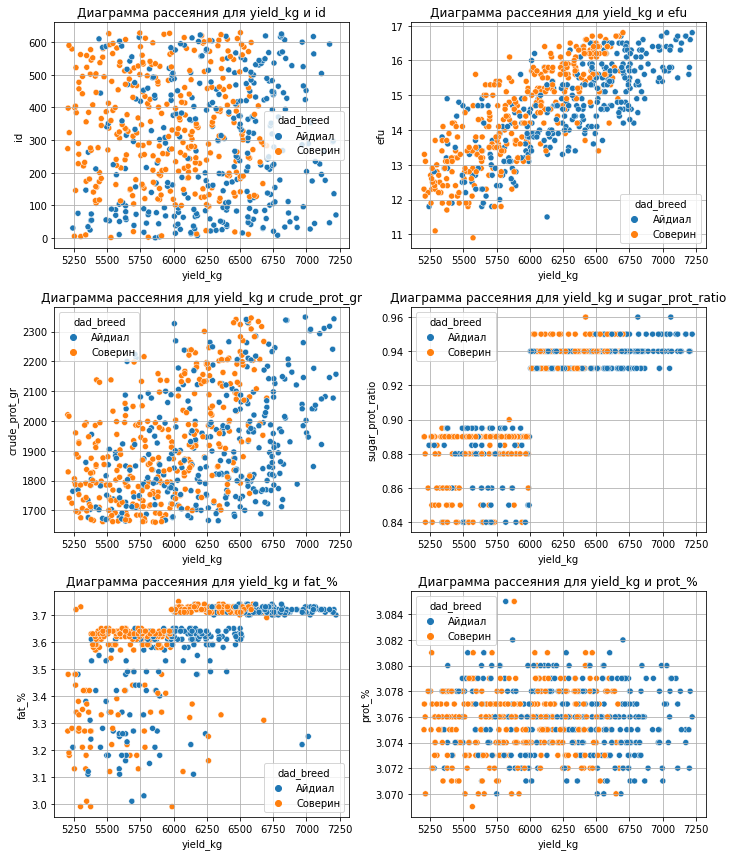

In [56]:
scatterplot_with_hue(df, 'dad_breed')

Здесь стоит отметить несколько моментов:

1) По всей видимости первые 100 коров из поголовья были зачаты быком породы Айдиал. После первой сотни начали поступать коровы зачатые быками обоих пород.
2) В среднем коровы зачатые быком породы Айдиал дают молока больше чем коровы зачатые Соверином, и коэффициент прироста удоя в зависимости от ЭКЕ у них лучше.
3) Удой коров зачатых Айдиалом повышается сильнее при росте сырого протеина в корме чем у коров зачатых Соверином.
4) Удой коров зачаты обеими породами отцов почти одинакого реагируют на рост СПО в корме.
5) Коровы зачатые Айдиалом и дающие жирное молоко, как правило дают его больше чем зачатые Соверином.
6) Связи между породами быков-отцов, удоем коров и содержанием белка в молоке практически нет

### Scatterplot'ы c учетом вкуса (tasty)

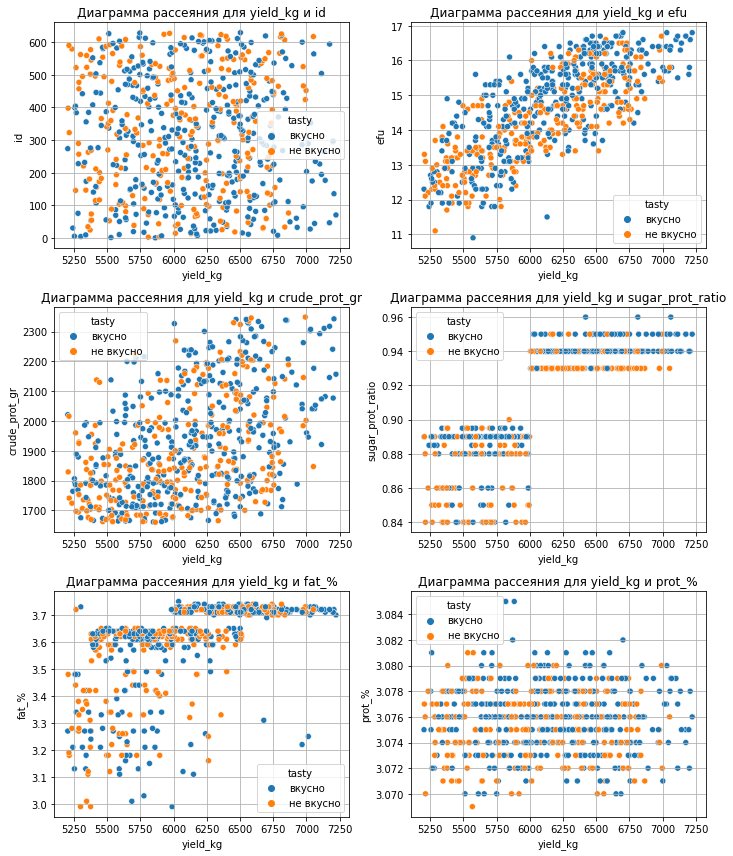

In [57]:
scatterplot_with_hue(df, 'tasty')

Данные по вкусу распределены практически случайным образом. Какой-то связи не выявлено.

### Scatterplot'ы c учетом возраста (age)

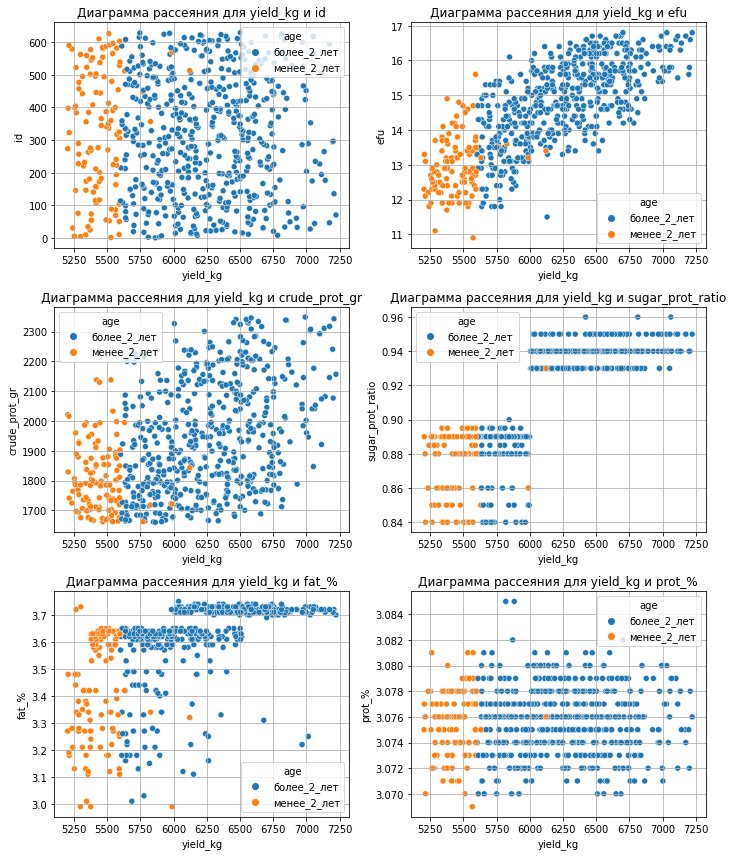

In [58]:
scatterplot_with_hue(df, 'age')

Здесь, стоит отметить одну ярко выраженную деталь. Коровы старше двух лет дают молока в разы больше чем молодые.

### Scatterplot'ы c учетом отца-быка (dad_name)

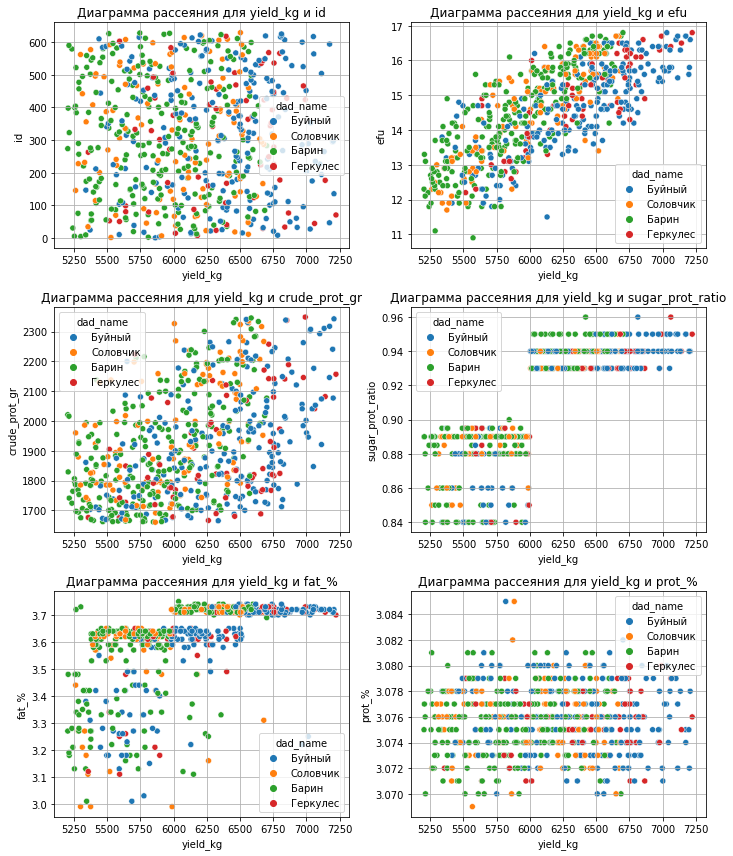

In [59]:
scatterplot_with_hue(df, 'dad_name')

Данные по отцам-быкам распределены практически случайным образом. Какой-то связи не выявлено.

### Вывод по корреляционному анализу.

Из проведенного корреляционного анализа можно выделить следующее:

    - Сильнее всего на Удой влияет количество ЭКЕ - зависимость линейная положительная и достаточно сильная. Обе породы одинаково хорошо реагируют на повышение ЭКЕ повышением удоя.
    - Есть слабая положительная линейная зависимость между содержанием сырого протеина в корме и количеством удоя, порода также одинакого реагируют на изменение количества белка в корме.
    - Сильная положительная линейная зависимость между СПО и удоем, обе породы одинаково хорошо реагируют на рост СПО в корме.
    - Тип пастбища никак не влияет на удой молока.
    - Вкус мало связан с какими-либо параметрами.
    - Коровы старше двух лет дают молока существенно больше.
    - Отец-бык мало влияет на удой своих детей.
    
Исходя из матрицы корреляций сильных зависимостей (>0,9) не выявлено, отсюда можно сделать вывод, что мультиколлинеарность в нашем случае отсутствует. Можно было бы предположить, что сырой протеин в корме и СПО имеют сильную связь- но это не так. Сырой протеин - абсолютная величина, а СПО зависит еще от сахара в корме. Либо можно было бы предположить что есть связь СПО и ЭКЕ. Но ЭКЕ - это каллорийность, а СПО всего лишь отношение сахара и протеина в корме (к тому же, сахар это углевод, калорийность его идентична каллорийности белка: 4 ккал на 1 гр, то есть меняя соотношение СПО - ЭКЕ может остаться прежней).
Единственный параметр который меня смущает - это увеличение жирности молока при увеличении удоя. Я ничего не понимаю в коровах, но могу предположить, что оно просто "так устроено" одна корова плодовитая, дает много питательного молока, другая "слабая" - дает меньше молока и она у неё более жидкое. Но в любом случае коэффициент корреляции у всех этих параметров ниже порога в 0,9.

## Обучение модели линейной регрессии

### Первая модель линейной регрессии

In [60]:
RANDOM_STATE = 42

X = df[['efu', 'crude_prot_gr', 'breed', 'sugar_prot_ratio', 'age', 'pasture_type', 'dad_breed']]
y = df['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'age', 'pasture_type', 'dad_breed']
num_col_names = ['efu', 'crude_prot_gr', 'sugar_prot_ratio']

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_num_scaled = scaler.transform(X_test[num_col_names])

# Преобразование категориальных признаков с использованием OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_cat = X_train[cat_col_names].astype(str)
X_test_cat = X_test[cat_col_names].astype(str)
X_train_ohe = encoder.fit_transform(X_train_cat)
X_test_ohe = encoder.transform(X_test_cat)
encoder_col_names = encoder.get_feature_names(cat_col_names)

# Объединение закодированных категориальных признаков с масштабированными числовыми
X_train_final = pd.concat([pd.DataFrame(X_train_num_scaled, columns=num_col_names), pd.DataFrame(X_train_ohe, columns=encoder_col_names)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_num_scaled, columns=num_col_names), pd.DataFrame(X_test_ohe, columns=encoder_col_names)], axis=1)

# Инициализация и обучение модели Linear Regression
model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_final, y_train)

# Получение предсказаний модели на тестовой выборке
y_pred = model_lr_1.predict(X_test_final)

# Рассчет коэффициента детерминации (R²)
r2 = r2_score(y_test, y_pred)
print(f"Коэффициент детерминации (R²) на тестовой выборке: {r2}")


# Анализ остатков с помощью графиков
residuals = y_test - y_pred

Коэффициент детерминации (R²) на тестовой выборке: 0.8189372677250858


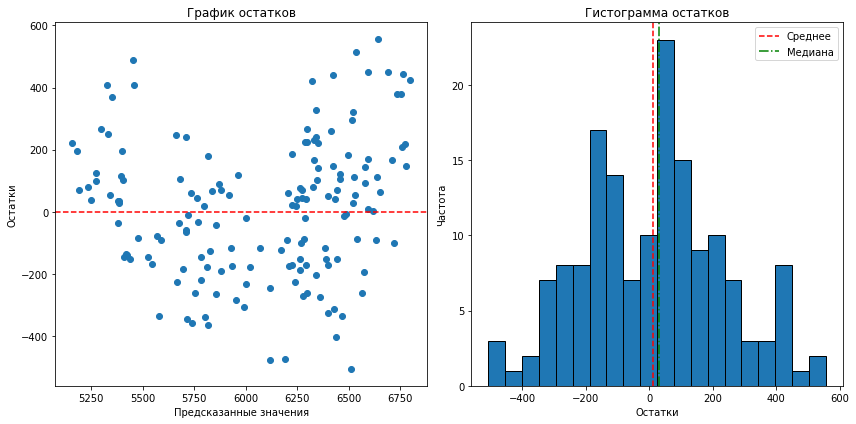

In [61]:
# Вычисление среднего и медианы остатков
mean_residuals = residuals.mean()
median_residuals = residuals.median()

# Создание фигуры и подграфиков
plt.figure(figsize=(12, 6))

# График остатков
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')

# Гистограмма остатков с медианой и средним
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label='Среднее')
plt.axvline(x=median_residuals, color='green', linestyle='-.', label='Медиана')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Истинные значения
y_test = np.array(y_test)

# Прогнозы модели
y_pred = np.array(y_pred)

# Вычисление MSE
mse = mean_squared_error(y_test, y_pred)

# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred)

# Вычисление RMSE
rmse = np.sqrt(mse)

print(f'MSE для первой модели: {mse}')
print(f'MAE для первой модели: {mae}')
print(f'RMSE для первой модели: {rmse}')

MSE для первой модели: 49614.05280566924
MAE для первой модели: 181.03715127327214
RMSE для первой модели: 222.7421217589283


R^2 = 0,82. Неплохо для первого раза первого проекта по МО. График представляет собой дугу - нелинейная связь между предсказаниями и остатками. Само распределение остатков несовсем симметрично и есть выбросы. А вот это плохо.
Также настораживают метрики:
MSE для первой модели: 49600
MAE для первой модели: 181
RMSE для первой модели: 222
Нужно посмотреть, удасться ли улучшить эти показатели.

### Вторая модель линейной регрессии

Проведем необходимые манипуляции с дф. А именно: Избавимся от нелинейности некоторых признаков СПО/удой и ЭКЕ/удой:

In [63]:
df['sug_prot_cat'] = (df['sugar_prot_ratio'] > 0.91).astype(int) #преобразуем СПО в категориальный признак
display(df.sample(10))

,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name,sug_prot_cat
197,198,6343,14.4,2063,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.62,3.079,вкусно,более_2_лет,Буйный,1
336,337,5513,14.5,1744,0.89,РефлешнСоверинг,Холмистое,Соверин,3.65,3.070,вкусно,менее_2_лет,Барин,0
35,36,6401,16.4,1768,0.93,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.073,вкусно,более_2_лет,Барин,1
393,394,6841,15.1,2010,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.72,3.076,вкусно,более_2_лет,Буйный,1
539,540,6280,15.8,2025,0.94,РефлешнСоверинг,Холмистое,Соверин,3.72,3.078,вкусно,более_2_лет,Барин,1
493,494,5477,13.3,1854,0.85,Вис Бик Айдиал,Равнинное,Соверин,3.62,3.074,не вкусно,менее_2_лет,Соловчик,0
483,484,6583,15.3,2205,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.72,3.071,не вкусно,более_2_лет,Буйный,1
252,253,5754,13.7,1945,0.89,РефлешнСоверинг,Холмистое,Соверин,3.63,3.078,вкусно,более_2_лет,Барин,0
468,469,6469,15.9,1834,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.62,3.076,вкусно,более_2_лет,Геркулес,1
594,595,6053,13.8,1753,0.93,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,вкусно,более_2_лет,Буйный,1


Введем новый признак ЭКЕ^2. 

In [64]:
df['efu_sq'] = df['efu'] ** 2
display(df.head())

,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name,sug_prot_cat,efu_sq
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин,0,163.84


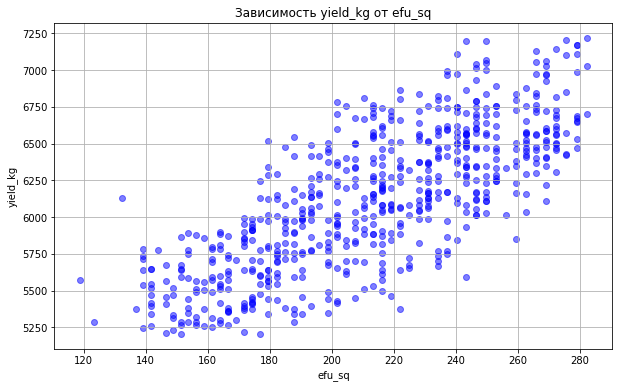

In [65]:
plt.figure(figsize=(10, 6)) #построим график зависимости:
plt.scatter(df['efu_sq'], df['yield_kg'], color='b', alpha=0.5)
plt.title('Зависимость yield_kg от efu_sq')
plt.xlabel('efu_sq')
plt.ylabel('yield_kg')
plt.grid(True)
plt.show()

Строим вторую модель с добавленным признаком:

In [66]:
X = df[['efu_sq', 'crude_prot_gr', 'breed', 'sug_prot_cat', 'age', 'pasture_type', 'dad_breed']]
y = df['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'age', 'pasture_type', 'dad_breed']
num_col_names = ['efu_sq', 'crude_prot_gr', 'sug_prot_cat']

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_num_scaled = scaler.transform(X_test[num_col_names])

# Преобразование категориальных признаков с использованием OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_cat = X_train[cat_col_names].astype(str)
X_test_cat = X_test[cat_col_names].astype(str)
X_train_ohe = encoder.fit_transform(X_train_cat)
X_test_ohe = encoder.transform(X_test_cat)
encoder_col_names = encoder.get_feature_names(cat_col_names)

# Объединение закодированных категориальных признаков с масштабированными числовыми
X_train_final = pd.concat([pd.DataFrame(X_train_num_scaled, columns=num_col_names), pd.DataFrame(X_train_ohe, columns=encoder_col_names)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_num_scaled, columns=num_col_names), pd.DataFrame(X_test_ohe, columns=encoder_col_names)], axis=1)

# Инициализация и обучение модели Linear Regression
model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_final, y_train)

# Получение предсказаний модели на тестовой выборке
y_pred = model_lr_1.predict(X_test_final)

# Рассчет коэффициента детерминации (R²)
r2 = r2_score(y_test, y_pred)
print(f"Коэффициент детерминации (R²) на тестовой выборке: {r2}")


# Анализ остатков с помощью графиков
residuals = y_test - y_pred

Коэффициент детерминации (R²) на тестовой выборке: 0.8436817494299889


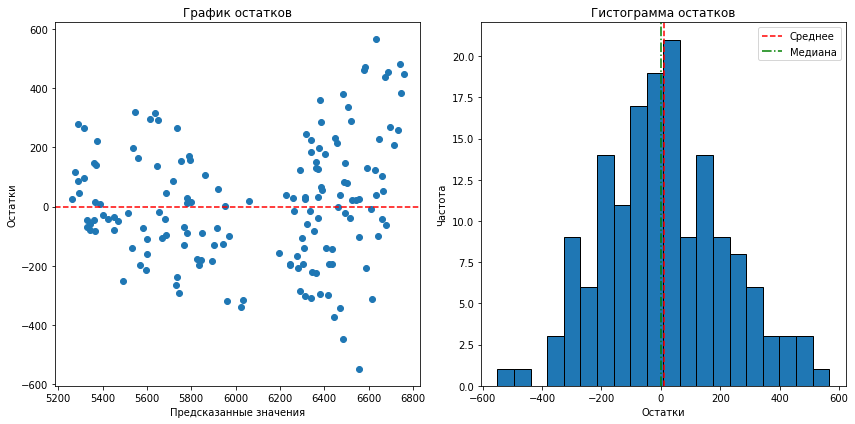

In [67]:
# Вычисление среднего и медианы остатков
mean_residuals = residuals.mean()
median_residuals = residuals.median()

# Создание фигуры и подграфиков
plt.figure(figsize=(12, 6))

# График остатков
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')

# Гистограмма остатков с медианой и средним
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label='Среднее')
plt.axvline(x=median_residuals, color='green', linestyle='-.', label='Медиана')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# Истинные значения
y_test = np.array(y_test)

# Прогнозы модели
y_pred = np.array(y_pred)

# Вычисление MSE
mse = mean_squared_error(y_test, y_pred)

# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred)

# Вычисление RMSE
rmse = np.sqrt(mse)

print(f'MSE для второй модели: {mse}')
print(f'MAE для второй модели: {mae}')
print(f'RMSE для второй модели: {rmse}')

MSE для второй модели: 42833.673395002035
MAE для второй модели: 163.89418108482272
RMSE для второй модели: 206.96297590390904


Результат вырос до 0,84. Но остатки на диаграмме рассеяния показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен, гистограмма распределения показывает некоторые улучшения, выбросы по концам немного сгладились
Также улучшились все 3 метрики:
MSE для второй модели: 42800
MAE для второй модели: 163
RMSE для второй модели: 206.

### Третья модель линейной регрессии

Добавим к признакам dad_name (его мы добавили в основной дф еще на этапе предобработки)

In [69]:
X = df[['efu_sq', 'crude_prot_gr', 'breed', 'sug_prot_cat', 'age', 'pasture_type', 'dad_breed', 'dad_name']]
y = df['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'age', 'pasture_type', 'dad_breed', 'dad_name']
num_col_names = ['efu_sq', 'crude_prot_gr', 'sug_prot_cat']

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_num_scaled = scaler.transform(X_test[num_col_names])

# Преобразование категориальных признаков с использованием OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_cat = X_train[cat_col_names].astype(str)
X_test_cat = X_test[cat_col_names].astype(str)
X_train_ohe = encoder.fit_transform(X_train_cat)
X_test_ohe = encoder.transform(X_test_cat)
encoder_col_names = encoder.get_feature_names(cat_col_names)

# Объединение закодированных категориальных признаков с масштабированными числовыми
X_train_final = pd.concat([pd.DataFrame(X_train_num_scaled, columns=num_col_names), pd.DataFrame(X_train_ohe, columns=encoder_col_names)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_num_scaled, columns=num_col_names), pd.DataFrame(X_test_ohe, columns=encoder_col_names)], axis=1)

# Инициализация и обучение модели Linear Regression
model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_final, y_train)

# Получение предсказаний модели на тестовой выборке
y_pred = model_lr_1.predict(X_test_final)

# Рассчет коэффициента детерминации (R²)
r2 = r2_score(y_test, y_pred)
print(f"Коэффициент детерминации (R²) на тестовой выборке: {r2}")


# Анализ остатков с помощью графиков
residuals = y_test - y_pred

Коэффициент детерминации (R²) на тестовой выборке: 0.862595335380899


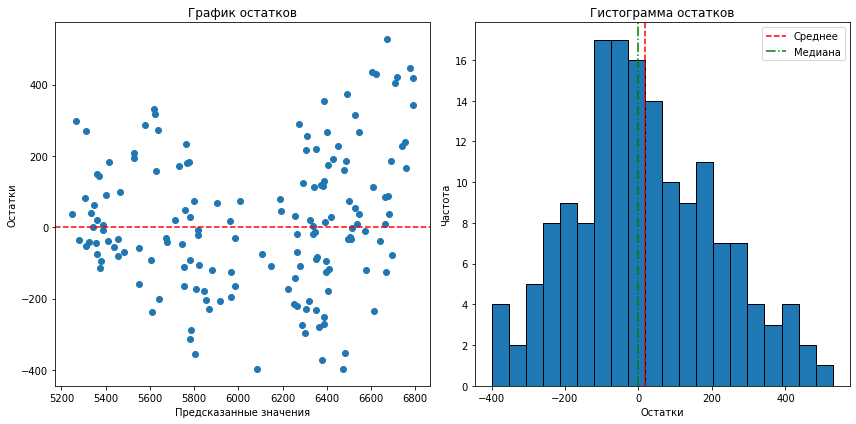

In [70]:
# Вычисление среднего и медианы остатков
mean_residuals = residuals.mean()
median_residuals = residuals.median()

# Создание фигуры и подграфиков
plt.figure(figsize=(12, 6))

# График остатков
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')

# Гистограмма остатков с медианой и средним
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label='Среднее')
plt.axvline(x=median_residuals, color='green', linestyle='-.', label='Медиана')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
# Истинные значения
y_test = np.array(y_test)

# Прогнозы модели
y_pred = np.array(y_pred)

# Вычисление MSE
mse = mean_squared_error(y_test, y_pred)

# Вычисление MAE
mae = mean_absolute_error(y_test, y_pred)

# Вычисление RMSE
rmse = np.sqrt(mse)

print(f'MSE для третьей модели: {mse}')
print(f'MAE для третьей модели: {mae}')
print(f'RMSE для третьей модели: {rmse}')

MSE для третьей модели: 37651.05165764615
MAE для третьей модели: 153.40357726217266
RMSE для третьей модели: 194.03878905426654


In [72]:
# Вычисляем среднее значение прогнозов
mean_pred = np.mean(y_pred)

# Задаем уровень доверия (обычно 95%)
confidence_level = 0.95

# Вычисляем стандартное отклонение прогнозов
std_dev = np.std(y_pred)
n = len(y_pred)

# Вычисляем стандартную ошибку среднего
std_error = std_dev / np.sqrt(n)

# Вычисляем критическое значение t-распределения
t_value = 1.96  # для уровня доверия 95% и n-1 степеней свободы

# Вычисляем доверительный интервал
margin_of_error = t_value * std_error
ci_lower = mean_pred - margin_of_error
ci_upper = mean_pred + margin_of_error

print("Доверительный интервал прогноза третьей модели:", (ci_lower.round(0), ci_upper.round(0)))

Доверительный интервал прогноза третьей модели: (5998.0, 6142.0)


Результат R^2 вырос до 0.86. Остатки на диаграмме рассеяния значительно "рассредоточились", по сравнению с первыми моделями, гистограмма распределения остатков также стала больше походить на нормальное.
Все три метрики значительно улучшились по сравнению с первыми двумя моделями:
MSE для третьей модели: 37600
MAE для третьей модели: 153
RMSE для третьей модели: 194

### Вывод по трем моделям линейной регрессии

Среди трех моделей построенных в рамках данной части можно с уверенностью сказать что лучшая из них это третья модель. Она Имеет наибольший коэффициент детерминации ~0,85 (против 0,818 у первой и 0,822 у второй). Также все метрики касающиеся ошибок у третьей модели минимальные если также сравнивать с двумя остальными моделями. MSE 3 модели = 41800 (против 49600 и 48600), MAE 3 модели = 163 (против 181 и 179) и RMSE 3 модели = 204 (против 222 и 220). Доверительный интервал модели (5998.0, 6139.0). Будем при прогнозировании удоя пользоваться 3 моделью.

### Прогнозирование удоя

Доработаем данные прогнозируемой выборки в соответвии с тренировочной:

In [73]:
display(cow_buy_df.head())
display(df.head())

,breed,pasture_type,dad_breed,dad_name,fat_current_%,prot_current_%,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name,sug_prot_cat,efu_sq
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин,0,163.84


In [74]:
cow_buy_df['efu_sq'] = ((df['efu'].mean())*1.05)**2
cow_buy_df['crude_prot_gr'] = int((df['crude_prot_gr'].mean())*1.05)
cow_buy_df['sugar_prot_ratio'] = (df['sugar_prot_ratio'].mean()) * 1.05
cow_buy_df['sug_prot_cat'] = (cow_buy_df['sugar_prot_ratio'] > 0.91).astype(int) #преобразуем СПО в категориальный признак
cow_buy_df['pasture_type'] = cow_buy_df['pasture_type'].str.capitalize()
display(cow_buy_df.head())

,breed,pasture_type,dad_breed,dad_name,fat_current_%,prot_current_%,age,efu_sq,crude_prot_gr,sugar_prot_ratio,sug_prot_cat
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.205675,2019,0.958772,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.205675,2019,0.958772,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.205675,2019,0.958772,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.205675,2019,0.958772,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.205675,2019,0.958772,1


In [75]:
cow_buy_df.rename(columns={'fat_current_%': 'fat_%', 'prot_current_%': 'prot_%'}, inplace=True) #немного дообработаем дф с коровами, пригодится
cow_buy_df_1 = cow_buy_df.copy()
cow_buy_df.head()

,breed,pasture_type,dad_breed,dad_name,fat_%,prot_%,age,efu_sq,crude_prot_gr,sugar_prot_ratio,sug_prot_cat
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.205675,2019,0.958772,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.205675,2019,0.958772,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.205675,2019,0.958772,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.205675,2019,0.958772,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.205675,2019,0.958772,1


In [76]:
cow_buy_df_1.drop(columns=['fat_%', 'sugar_prot_ratio', 'prot_%'], inplace=True)
cow_buy_df_1.head()

,breed,pasture_type,dad_breed,dad_name,age,efu_sq,crude_prot_gr,sug_prot_cat
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,более_2_лет,233.205675,2019,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,менее_2_лет,233.205675,2019,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,более_2_лет,233.205675,2019,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,более_2_лет,233.205675,2019,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,более_2_лет,233.205675,2019,1


In [77]:
# Получение списка столбцов в правильном порядке из другого DataFrame (например, X_test_final)
columns_order = X.columns

# Переупорядочивание столбцов в X_cow_final в соответствии с порядком columns_order
cow_buy_df_1 = cow_buy_df_1.reindex(columns=columns_order, fill_value=0)


In [78]:
columns_X = X.columns
# Выбор только необходимых столбцов из cow_buy_df_1, которые есть в X
cow_buy_df_1 = cow_buy_df_1[columns_X]


In [79]:
cow_buy_df_1.head()


,efu_sq,crude_prot_gr,breed,sug_prot_cat,age,pasture_type,dad_breed,dad_name
0,233.205675,2019,Вис Бик Айдиал,1,более_2_лет,Холмистое,Айдиал,Геркулес
1,233.205675,2019,Вис Бик Айдиал,1,менее_2_лет,Равнинное,Соверин,Буйный
2,233.205675,2019,РефлешнСоверинг,1,более_2_лет,Равнинное,Соверин,Барин
3,233.205675,2019,РефлешнСоверинг,1,более_2_лет,Холмистое,Айдиал,Буйный
4,233.205675,2019,РефлешнСоверинг,1,более_2_лет,Равнинное,Айдиал,Буйный


In [80]:
X.head()

,efu_sq,crude_prot_gr,breed,sug_prot_cat,age,pasture_type,dad_breed,dad_name
0,201.64,1743,Вис Бик Айдиал,0,более_2_лет,Равнинное,Айдиал,Буйный
1,163.84,2138,Вис Бик Айдиал,0,менее_2_лет,Равнинное,Соверин,Соловчик
2,196.00,1854,РефлешнСоверинг,0,более_2_лет,Холмистое,Соверин,Барин
3,153.76,2012,РефлешнСоверинг,0,более_2_лет,Холмистое,Айдиал,Буйный
4,163.84,1675,Вис Бик Айдиал,0,менее_2_лет,Равнинное,Соверин,Барин


In [81]:
# Преобразование категориальных признаков в cow_buy_df с использованием OneHotEncoder
X_cow_cat = cow_buy_df_1[cat_col_names].astype(str)
X_cow_ohe = encoder.transform(X_cow_cat)

# Масштабирование числовых признаков в cow_buy_df
X_cow_scaled = scaler.transform(cow_buy_df_1[num_col_names])

# Объединение закодированных категориальных признаков с масштабированными числовыми для cow_buy_df
X_cow_final = pd.concat([pd.DataFrame(X_cow_scaled, columns=num_col_names), pd.DataFrame(X_cow_ohe, columns=encoder_col_names)], axis=1)
# Получение предсказаний модели на данных из cow_buy_df
y_pred_yield = model_lr_1.predict(X_cow_final)

print(y_pred_yield.round(0))

[6550. 6294. 6288. 6595. 6542. 6341. 6550. 6502. 6288. 6387. 6349. 6549.
 6550. 6087. 6288. 6595. 6349. 6341. 6502. 6542.]


Вывод по прогнозу. Данные по удою получены, они составляют (6550, 6294, 6288, 6595, 6542, 6341, 6550, 6502, 6288, 6387, 6349, 6549, 6550, 6087, 6288, 6595, 6349, 6341, 6502, 6542). По данному параметру все коровы подходят фермеру, годовой удой у каждой из них прогнозируется свыше 6000 кг.

## Обучение модели логистической регрессии

### Создание и настройка модели

In [82]:
df.head()

,id,yield_kg,efu,crude_prot_gr,sugar_prot_ratio,breed,pasture_type,dad_breed,fat_%,prot_%,tasty,age,dad_name,sug_prot_cat,efu_sq
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин,0,163.84


In [83]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

# разбиваем признаки на входные и целевой
X = df[['efu_sq', 'crude_prot_gr', 'sug_prot_cat', 'breed', 'pasture_type', 'dad_breed', 'fat_%', 'prot_%', 'age']]
y = df['tasty']

# разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
# Преобразование категориальных признаков с использованием OneHotEncoder
cat_col_names = ['breed','age', 'pasture_type', 'dad_breed']
X_train_cat = X_train[cat_col_names].astype(str)
X_train_ohe = encoder.fit_transform(X_train_cat)
encoder_col_names = encoder.get_feature_names(cat_col_names)
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=cat_col_names))

# Объединение закодированных категориальных признаков с масштабированными числовыми
X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.drop(columns=cat_col_names).columns), df_ohe], axis=1)

# создаём объект для работы с моделью
clf = LogisticRegression()

# обучаем модель на данных
clf = clf.fit(X_train_final, y_train)

# Подготовка тестовых данных
X_test_cat = X_test[cat_col_names].astype(str)
X_test_ohe = encoder.transform(X_test_cat)
X_test_scaled = scaler.transform(X_test.drop(columns=cat_col_names))
X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=X_test.drop(columns=cat_col_names).columns), pd.DataFrame(X_test_ohe, columns=encoder_col_names)], axis=1)

# получаем прогнозные метки классов
y_pred = clf.predict(X_test_final)

# проводим оценку точности
acc = accuracy_score(y_test, y_pred)
# Рассчитываем Recall
recall = recall_score(y_test, y_pred, pos_label='вкусно')
# Рассчитываем Precision
precision = precision_score(y_test, y_pred, pos_label='вкусно')

print('Accuracy:', acc)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.6708860759493671
Recall: 0.7731958762886598
Precision: 0.7142857142857143


In [84]:
cm = confusion_matrix(y_test, y_pred) #построим матрицу ошибок

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[75 22]
 [30 31]]


Вывод по модели: Общая точность составляет 67%, что не идеально. Параметр precision составляет 71%, recall 77%.
Модель допускает 22 ошибки первого рода и 30 ошибок второго. Для фермера важно чтобы молоко точно было вкусным, поэтому предсказания типа False Positive надо минимизировать - это критично для него. Для этого нужно немного "поиграть" со значениями порога для того чтобы максимизировать метрику precision.

In [85]:
# Получаем вероятности принадлежности к классам
y_pred_prob = clf.predict_proba(X_test_final)
print(y_pred_prob)

[[0.48639184 0.51360816]
 [0.71859995 0.28140005]
 [0.60709813 0.39290187]
 [0.28188669 0.71811331]
 [0.76846013 0.23153987]
 [0.81051962 0.18948038]
 [0.2373639  0.7626361 ]
 [0.68089277 0.31910723]
 [0.77661253 0.22338747]
 [0.32398313 0.67601687]
 [0.23560319 0.76439681]
 [0.50265542 0.49734458]
 [0.44776187 0.55223813]
 [0.552607   0.447393  ]
 [0.47681638 0.52318362]
 [0.46641917 0.53358083]
 [0.64446249 0.35553751]
 [0.82948256 0.17051744]
 [0.63999329 0.36000671]
 [0.31056875 0.68943125]
 [0.56038847 0.43961153]
 [0.63831588 0.36168412]
 [0.77343982 0.22656018]
 [0.27818453 0.72181547]
 [0.77118117 0.22881883]
 [0.70089206 0.29910794]
 [0.58481203 0.41518797]
 [0.73856364 0.26143636]
 [0.4914089  0.5085911 ]
 [0.6562151  0.3437849 ]
 [0.31975914 0.68024086]
 [0.42578334 0.57421666]
 [0.36741333 0.63258667]
 [0.7467699  0.2532301 ]
 [0.60888061 0.39111939]
 [0.69828379 0.30171621]
 [0.60259005 0.39740995]
 [0.66932275 0.33067725]
 [0.44212897 0.55787103]
 [0.76257558 0.23742442]


In [86]:
# Выбираем новый порог 
new_threshold = 0.83

# Классифицируем по новому порогу
y_pred_new = (y_pred_prob[:,0] >= new_threshold).astype(int)
y_pred_new = np.where(y_pred_new == 1, 'вкусно', 'не вкусно')
# Рассчитываем Recall и Precision с новым порогом

recall_new = recall_score(y_test, y_pred_new, pos_label='вкусно')
precision_new = precision_score(y_test, y_pred_new, pos_label='вкусно')

print("Новый accuracy:", acc)
print("Новый порог:", new_threshold)
print("Новое значение Recall:", recall_new)
print("Новое значение Precision:", precision_new)


Новый accuracy: 0.6708860759493671
Новый порог: 0.83
Новое значение Recall: 0.061855670103092786
Новое значение Precision: 0.8571428571428571


Не исключили ложноположительную ошибку. Попробуем увеличить порог.

In [87]:
# Выбираем новый порог 
new_threshold = 0.85

# Классифицируем по новому порогу
y_pred_new = (y_pred_prob[:,0] >= new_threshold).astype(int)
y_pred_new = np.where(y_pred_new == 1, 'вкусно', 'не вкусно')
# Рассчитываем Recall и Precision с новым порогом

recall_new = recall_score(y_test, y_pred_new, pos_label='вкусно')
precision_new = precision_score(y_test, y_pred_new, pos_label='вкусно')

print("Новый accuracy:", acc)
print("Новый порог:", new_threshold)
print("Новое значение Recall:", recall_new)
print("Новое значение Precision:", precision_new)

Новый accuracy: 0.6708860759493671
Новый порог: 0.85
Новое значение Recall: 0.041237113402061855
Новое значение Precision: 1.0


Исключили ложноположительную ошибку, но можно ли снизить ложноотрицательную? хотя бы немного? Попробуем:

In [88]:
# Выбираем новый порог 
new_threshold = 0.84

# Классифицируем по новому порогу
y_pred_new = (y_pred_prob[:,0] >= new_threshold).astype(int)
y_pred_new = np.where(y_pred_new == 1, 'вкусно', 'не вкусно')
# Рассчитываем Recall и Precision с новым порогом

recall_new = recall_score(y_test, y_pred_new, pos_label='вкусно')
precision_new = precision_score(y_test, y_pred_new, pos_label='вкусно')

print("Новый accuracy:", acc)
print("Новый порог:", new_threshold)
print("Новое значение Recall:", recall_new)
print("Новое значение Precision:", precision_new)

Новый accuracy: 0.6708860759493671
Новый порог: 0.84
Новое значение Recall: 0.061855670103092786
Новое значение Precision: 1.0


По итогу, чтобы свести ошибку первого рода к минимуму, необходимо задать минимальный порог в 0,84. Accuracy практически неизменилась, а recall ожидаемо упала до минимума. Перейдем к прогнозированию вкуса молока. 

### Прогнозирование вкуса молока

Подготовим данные для прогнозирования:

In [89]:
cow_buy_df_2 = cow_buy_df.copy()
cow_buy_df_2['efu_sq'] = ((df['efu'].mean())*1.05)**2
cow_buy_df_2['crude_prot_gr'] = int((df['crude_prot_gr'].mean())*1.05)
cow_buy_df_2['sugar_prot_ratio'] = (df['sugar_prot_ratio'].mean()) * 1.05
cow_buy_df_2['sug_prot_cat'] = (cow_buy_df_2['sugar_prot_ratio'] > 0.91).astype(int) #преобразуем СПО в категориальный признак
cow_buy_df_2['pasture_type'] = cow_buy_df_2['pasture_type'].str.capitalize()
cow_buy_df_2.rename(columns={'fat_current_%': 'fat_%', 'prot_current_%': 'prot_%'}, inplace=True)
cow_buy_df_2.drop(columns=['dad_name', 'sugar_prot_ratio'], inplace=True)
display(cow_buy_df_2.head())

,breed,pasture_type,dad_breed,fat_%,prot_%,age,efu_sq,crude_prot_gr,sug_prot_cat
0,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,233.205675,2019,1
1,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,233.205675,2019,1
2,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,233.205675,2019,1
3,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,233.205675,2019,1
4,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,233.205675,2019,1


In [90]:
# Получение списка столбцов в правильном порядке из другого DataFrame (например, X_test_final)
columns_order2 = X.columns

# Переупорядочивание столбцов в X_cow_final в соответствии с порядком columns_order
cow_buy_df_2 = cow_buy_df_2.reindex(columns=columns_order2, fill_value=0)
cow_buy_df_2.head()

,efu_sq,crude_prot_gr,sug_prot_cat,breed,pasture_type,dad_breed,fat_%,prot_%,age
0,233.205675,2019,1,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет
1,233.205675,2019,1,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет
2,233.205675,2019,1,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет
3,233.205675,2019,1,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет
4,233.205675,2019,1,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет


In [91]:
display(X.head())

,efu_sq,crude_prot_gr,sug_prot_cat,breed,pasture_type,dad_breed,fat_%,prot_%,age
0,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет
1,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет
2,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет
3,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет
4,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет


In [92]:
# Преобразование категориальных признаков в cow_buy_df с использованием OneHotEncoder
X_cow_cat = cow_buy_df_2[cat_col_names].astype(str)
X_cow_ohe = encoder.transform(X_cow_cat)

# Масштабирование числовых признаков в cow_buy_df
X_cow_scaled = scaler.transform(cow_buy_df_2.drop(columns=cat_col_names))

In [93]:

# Объединение закодированных категориальных признаков с масштабированными числовыми для cow_buy_df
X_cow_final = pd.concat([pd.DataFrame(X_cow_scaled, columns=cow_buy_df_2.drop(columns=cat_col_names).columns), pd.DataFrame(X_cow_ohe, columns=encoder_col_names)], axis=1)
display(X_cow_final.head())

,efu_sq,crude_prot_gr,sug_prot_cat,fat_%,prot_%,breed_РефлешнСоверинг,age_менее_2_лет,pasture_type_Холмистое,dad_breed_Соверин
0,0.525538,0.536726,0.807856,-0.168258,0.134930,0.0,0.0,1.0,0.0
1,0.525538,0.536726,0.807856,-0.413233,2.049149,0.0,1.0,0.0,1.0
2,0.525538,0.536726,0.807856,-0.107014,-0.630758,1.0,0.0,0.0,1.0
3,0.525538,0.536726,0.807856,-1.270647,-5.607727,1.0,0.0,1.0,0.0
4,0.525538,0.536726,0.807856,0.199205,-0.630758,1.0,0.0,0.0,0.0


In [94]:
# Получение предсказаний модели на данных из cow_buy_df
y_pred_tasty = clf.predict(X_cow_final)

print(y_pred_tasty)

['вкусно' 'вкусно' 'вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'вкусно'
 'вкусно' 'вкусно' 'вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'вкусно'
 'вкусно' 'вкусно' 'вкусно' 'не вкусно' 'не вкусно' 'не вкусно']


С порогом в 0,5 молоко 11 коров прогнозируется вкусным, посмотрим, что будет после увеличения порога до найденных ранее 0,84:

In [95]:
# Получаем вероятности принадлежности к классам
y_pred_tasty_prob = clf.predict_proba(X_cow_final)
print(y_pred_tasty_prob)

[[0.69565003 0.30434997]
 [0.6238074  0.3761926 ]
 [0.51825605 0.48174395]
 [0.45043087 0.54956913]
 [0.48730715 0.51269285]
 [0.18265068 0.81734932]
 [0.69565003 0.30434997]
 [0.62688108 0.37311892]
 [0.51825605 0.48174395]
 [0.69818744 0.30181256]
 [0.37048134 0.62951866]
 [0.48679884 0.51320116]
 [0.22974453 0.77025547]
 [0.6839396  0.3160604 ]
 [0.51825605 0.48174395]
 [0.51672757 0.48327243]
 [0.74365227 0.25634773]
 [0.17394842 0.82605158]
 [0.48795093 0.51204907]
 [0.48730715 0.51269285]]


In [96]:
# Классифицируем по новому порогу
y_pred_tasty_new = (y_pred_tasty_prob[:,0] >= new_threshold).astype(int)
y_pred_tasty_new = np.where(y_pred_tasty_new == 1, 'вкусно', 'не вкусно')
print(y_pred_tasty_new)

['не вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно'
 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно'
 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно' 'не вкусно'
 'не вкусно' 'не вкусно']


После ужесточения требований к молоку, результаты ожидаемо ухудшились. Вкус молока ни одной из коров не прогнозируется подходящим. Похоже, фермеру не повезло, коров брать не надо!

### Добавление данных к датафрейму cow_buy_df

Добавим результаты:

In [97]:
cow_buy_df['pred_yield'] = y_pred_yield
cow_buy_df['pred_tasty'] = y_pred_tasty_new
display(cow_buy_df.head())

,breed,pasture_type,dad_breed,dad_name,fat_%,prot_%,age,efu_sq,crude_prot_gr,sugar_prot_ratio,sug_prot_cat,pred_yield,pred_tasty
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.205675,2019,0.958772,1,6550.071357,не вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.205675,2019,0.958772,1,6294.190427,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.205675,2019,0.958772,1,6288.013765,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.205675,2019,0.958772,1,6594.858790,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.205675,2019,0.958772,1,6542.226355,не вкусно


In [98]:
cow_buy_df.shape

(20, 13)

### Выводы по классификации

В рамках работы над данной главой была построена модель классификации данных.
Целевой признак выбран - вкус молока, данный признак категориальный.
Использовались данные из генеральной совокупности ferma_main. 
В результате прогнозирования вкуса молока у выбранного стада коров было предсказано, что, скорее всего, все молоко всех коров из данной выборки соответствует требованиям фермера.

## Итоговые выводы

В рамках данного заказа по анализу данных и построению модели были проведены следующие работы:

    - Были загружены и первично изучены все полученные данные;
    - Была проведена предобработка данных, которая включала анализ данных на странные значения, пропуски, дубликаты. Также во время предобработки были склеяны два датфрейма (основной дф и дф с именами отца) по ключу id. 
    - Исследовательский анализ данных выявил ряд особенностей, которые пригодились при построении моделей линейной регрессии и логистической регрессии. (Влияние породы, возраста, содержания корма и его количества на удой и вкус молока).
    - Была построена модель линейной регрессии для прогнозирования количества удоя молока у отобранных фермером коров. R2 у данной модели после всех улучшений и доработок в данных составила 0,86. Остальные метрики: MSE 37600, MAE 153, RMSE  194. Что по-всей видимости является приемлимым результатом исходя из данных которые были предоставлены заказчиком.
    - Была построена модель логистической регрессии для прогнозирования вкуса молока в выбранном стаде коров. Фермеру было важно, чтобы молоко было вкусным, поэтому у данной модели был увеличен порог классификации до 0,84. После всех улучшений и дополнения в данных метрики полученной модели составили: accuracy: 0,68; Recall: 0,06; Precision: 1,0.
    
В результате прогнозирования было выявлено, что все 20 коров из стада должны соответствовать требованиям фермера по удою молока, но к сожалению, по всей видимости, их молоко не будет соответствовать вкусовым ожиданиям фермера.

Следует добавить, что фермеру при выборе коров стоит больше уделять внимание корму, породе и возрасту коров. Тип пастбища, имя отца быка и его порода играют слабую роль в достижении заданных параметров.

Обе модели, и линейной и логистической регрессии имеют средние параметры точности, наверняка их можно было бы улучшить немного "поиграя" с признаками. Но в целом, результат 0,86 кажется неплохим для первого раза у линейной регрессии. У логистической результаты скромнее, но и сам параметр трудно предсказуем на мой взгляд. Мы как могли нивелировали риски за счет увеличения метрики precision. Точность модели можно было бы поднять за счет поиска и добавления новых обучающих признаков.